# Simple Source Time Function Inversion
#### Written by James Smith, Ph.d
##### Modified by Lucas Sawade

The method uses observed data (processed according to FieldDataProcessing.ipynb)
and synthetic data (from SPECFEM3D) and applies a simple linear inversion formula:

\begin{equation}
S(\omega)^{*} = \frac{u^{t}d^{*}}{u^{t}u^{*}}
\end{equation}

where u is the simulated wavefield and d is the observed wavefield.

## Load Observed and Synthetic Wavefield

Loading and plotting an observed and synthetic wavefield for further processing.

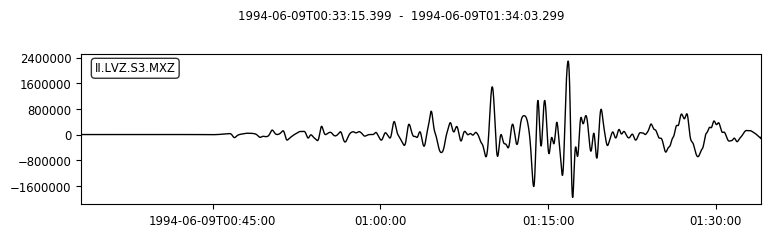

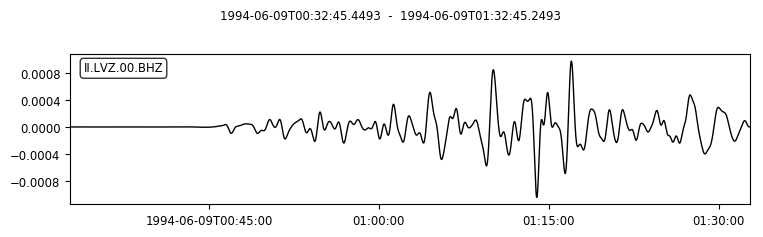

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import figure
from obspy import read, read_inventory, UTCDateTime
import glob, os

# First we read in the observed and synthetic data and plot a single trace
# Load traces. [SU == Seismic Unix?]

# Instead of reading in James' stuff read in earthquakes?
# field_obs = read('./data/observed', unpacked_headers=True)     # processed field data (720 traces)
# specfem3d_syn = read('./data/0_dz_SU', unpacked_headers= True) # Green's function from SPECFEM3D (720 traces)

eqID = "C060994A"

# Define location of the synthetics
synthetics_dir = "../data/" + eqID + "/seismograms/syn/"
synthetics_files = synthetics_dir + "*.sacan"

# Define location of the observed data
observed_dir = "../data/" + eqID + "/seismograms/obs/"
observed_files = observed_dir + "*.mseed"

# Response files
response_dir = "../data/" + eqID + "/station_data/"
# Read Station XML as inventory
obs_inv = read_inventory(os.path.join(response_dir, "station.xml"))

# Create list of all files in the directory
field_obs = read(observed_files)
specfem3d_syn = read(synthetics_files)

# I don't know what's happening here... Are there multiple traces?
station = "II.LVZ"
trace_id = station +"*"
field_trace = field_obs.select(id=trace_id, component="Z").traces[0] # Trace about ~10 m away from source
syn_trace = specfem3d_syn.select(id=trace_id, component="Z").traces[0] # Trace about ~10 m away from source

# Process synthetic traces
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='hann')

# Process observed traces
field_trace.detrend('constant')
field_trace.taper(max_percentage=0.05,type='hann')

# Remove the responses from the observed trace using the inventory
pre_filt = [0.001, 0.005, 45, 50]
field_trace.remove_response(inventory=obs_inv, pre_filt=pre_filt, output="DISP",water_level=60)

# Bandpass filter both traces
syn_trace.filter("highpass", freq=0.005, zerophase=True)
field_trace.filter("bandpass", freqmin=0.005, freqmax=0.03,zerophase=True)

# Resampling
syn_trace.resample(sampling_rate=10)
field_trace.resample(sampling_rate=10)

# Plot both traces
syn_trace.plot();
field_trace.plot();

## Make traces equal before finding time shift

As of now, the traces probably have completely different time sampling. 
To accurately perform the cross correlation, we need to actually make
the trace equal in discrete nature. The simplest way of doing this is to
interpolate the observed trace to the timing and sampling of the synthetic
trace.

36480
35999
36479
35699


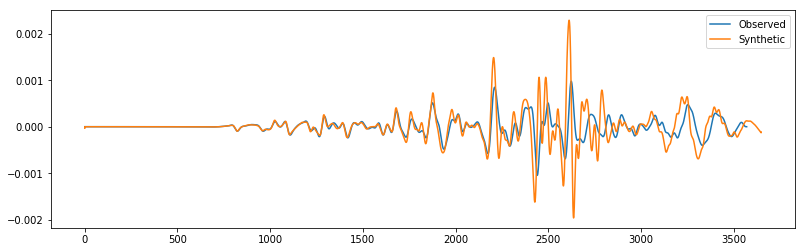

In [50]:
print(syn_trace.stats.npts)
print(field_trace.stats.npts)

# Interpolate the field_trace
field_trace.interpolate(sampling_rate=1/syn_trace.stats.delta,
                        starttime=syn_trace.stats.starttime,
                        method="cubic")

# Interpolate the syn_trace
syn_trace.interpolate(sampling_rate=1/syn_trace.stats.delta,
                      starttime=syn_trace.stats.starttime,
                      method="cubic")

# Plot interpolation results
w,h = figure.figaspect(0.3)
fig = plt.figure(figsize=[w,h])
ax = plt.axes()
plt.plot(field_trace.times(), field_trace.data, label="Observed")
plt.plot(syn_trace.times(), syn_trace.data, label="Synthetic")
plt.legend(loc=0)

print(syn_trace.stats.npts)
print(field_trace.stats.npts)

## Cut the traces

In [51]:
# Set times for trimming. Note that the time window here is arbitrary
# Later the window info of P-Arrival should be used.
beginTime = UTCDateTime(syn_trace.stats.starttime + 750)
endTime = UTCDateTime(beginTime + 150)

# Trim Synthetic trace
syn_trace.trim(beginTime, endTime)

# Trim Observed Trace
# beginTime = UTCDateTime(field_trace.stats.starttime)
field_trace.trim(beginTime, endTime)

# Plot Cut Results
w,h = figure.figaspect(0.3)
fig = plt.figure(figsize=[w,h])
ax = plt.axes()
plt.plot(field_trace.times(), field_trace.data, label="Shifted Observed")
plt.plot(syn_trace.times(), syn_trace.data, label="Synthetic")
plt.legend(loc=0)

## Taper the traces

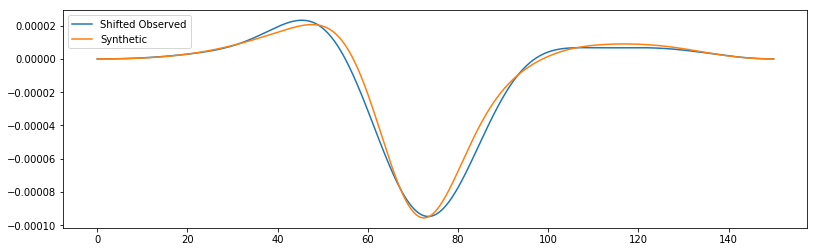

In [52]:
# Taper traces
syn_trace.taper(type="hann", max_percentage=0.5)
field_trace.taper(type="hann", max_percentage=0.5)

# Plot Taper results
w,h = figure.figaspect(0.3)
fig = plt.figure(figsize=[w,h])
ax = plt.axes()
plt.plot(field_trace.times(), field_trace.data, label="Shifted Observed")
plt.plot(syn_trace.times(), syn_trace.data, label="Synthetic")
plt.legend(loc=0)

## Setup Cosine taper to filter the traces:

We now generate the frequency filter that has already been applied ot the processed field data. We plot the filter to verify.

In [53]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
npts = field_trace.stats.npts # resampled trace so different from FieldDataProcessing
nfft = _npts2nfft(npts)

# Where does the tukey window number come from?
eq_pos = signal.tukey(201, alpha=0.25)
eq_pos = np.pad(eq_pos, 4,'constant',constant_values=0)
eq_pos.resize(int(nfft/2))
eq_neg = eq_pos[::-1]
syn_taper = np.append(eq_pos, eq_neg)

############# Sample spacing ##########################
dt = syn_trace.stats.delta   ####### IMPORTANT ########
freqs = fftfreq(nfft, d=dt)  ##########################
#######################################################

# Plot the filter and the spectra...
plt.plot(freqs,syn_taper, label="Cosine Taper on GrF")
plt.plot(freqs,np.abs(fft(field_trace.data/np.max(field_trace.data), n=nfft))
              /np.max(np.abs(fft(field_trace.data/np.max(field_trace.data), n=nfft))),
         color="black", label="Field Data")
plt.plot(freqs,np.abs(fft(syn_trace.data/np.max(syn_trace.data), n=nfft))\
               /np.max(np.abs(fft(syn_trace.data/np.max(syn_trace.data), n=nfft))), 
         color="red", label="Green's Function")
plt.xlim([-1/30, 1/30])
plt.plot(freqs[0:120],eq_pos[0:120])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.ylabel('Gain');

## Actual change into the Frequency Domain

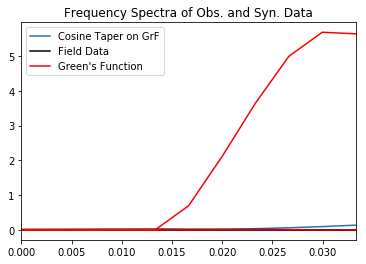

In [59]:
# Normalize the synthetic data
# syn_trace.data /= np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= np.max(np.abs(syn_trace.data))

# Taper the synthetic data in the frequency domain
fftsyn = fft(syn_trace.data, n=nfft)
fftsyn *= syn_taper

# Normalize field data?
# field_trace.data/= max(field_trace.data)
fftfield = fft(field_trace.data, n=nfft) # What are we not normalizing the field traces?


# Plot the spectra
plt.figure()
plt.title("Frequency Spectra of Obs. and Syn. Data")
plt.plot(freqs,syn_taper, label="Cosine Taper on GrF")
plt.plot(freqs,np.abs(fftfield), color="black", label="Field Data")
plt.plot(freqs,np.abs(fftsyn), color="red", label="Green's Function")
plt.xlim([0, 1/30])
plt.legend();

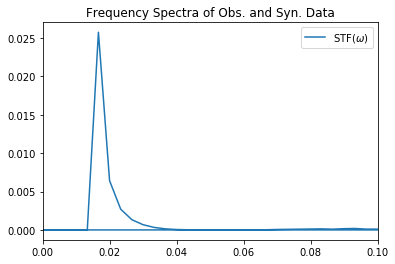

In [62]:
# Create empty complex array
stf = np.zeros(fftsyn.shape, dtype=np.complex)

# Number of elements in frequency vector to be considered
n_el = 100

# Find where synthetics are non-zero
posnz = np.nonzero(np.abs(fftsyn[0:n_el]))

# Find elements of synthetics that are zero
posz = np.where(fftsyn[0:n_el])

# Invert for sourcetimefunction
stf[posnz] = (fftsyn[posnz].T*fftfield[posnz].conj().T)\
            /(fftsyn[posnz].T*fftsyn[posnz].conj().T)


stf = stf.conj().T


# Plot the spectra
plt.figure()
plt.title("Frequency Spectra of Obs. and Syn. Data")
plt.plot(freqs,np.abs(stf), label="STF($\omega$)")
plt.xlim([0, 1/10])
plt.legend();

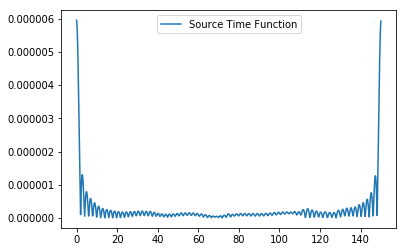

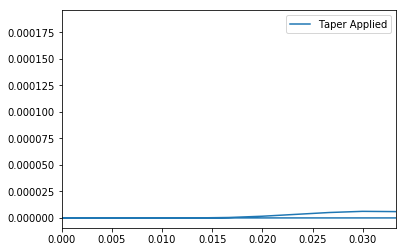

In [64]:
# filter with cosine taper
stf *= syn_taper

# Plot the tapered 
plt.plot(syn_trace.times(),np.abs(ifft(stf,n=syn_trace.stats.npts)), label="Source Time Function")
plt.legend()
plt.figure()
plt.plot(freqs, np.abs(stf))
plt.xlim([0, 1/30])
plt.legend(['Taper Applied', 'STF after applying Taper'])

(0, 0.03333333333333333)

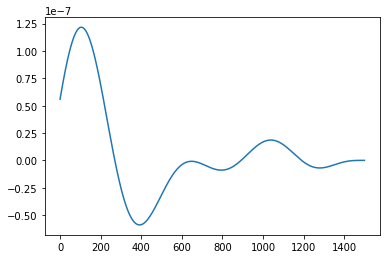

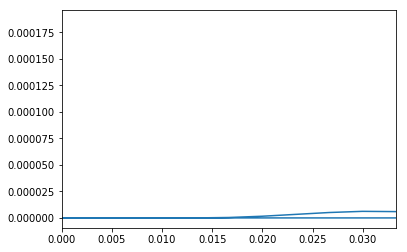

In [65]:
from obspy import Trace
st = Trace(data=np.abs(ifft(stf,n=nfft))[0:npts])
st.stats.delta=syn_trace.stats.delta
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass', freqmin=1/150, freqmax=1/40,zerophase=True)
plt.plot(st)
plt.figure()
plt.plot(freqs, np.abs(stf))
plt.xlim([0, 1/30])

## Load original traces

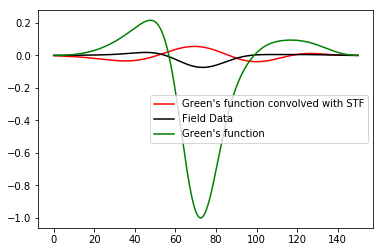

In [66]:
# Now convolve the source with the Green's Function
from obspy.core import Trace
from numpy.fft import *


# Convolve STF with Green's Function which is the synthetic traces...
convolved_Green=np.abs(ifft(fftsyn*fft(st.data,n=nfft), n=nfft)[0:npts])
synGreen = Trace(data=convolved_Green)
synGreen.stats.delta=syn_trace.stats.delta
synGreen.stats.starttime= syn_trace.stats.starttime
synGreen.filter('bandpass',freqmin=1/150,freqmax=1/40,zerophase=True)
w = np.linalg.norm(synGreen.data, ord=2)
synGreen.data /= w


w = np.linalg.norm(field_trace.data, ord=2)
field_trace.data /= w

plt.plot(synGreen.times(),synGreen.data,color="red")
plt.plot(field_trace.times(),field_trace.data, color="black")
plt.plot(syn_trace.times(),syn_trace.data,color="green")
plt.legend(["Green's function convolved with STF", "Field Data", "Green's function"])
# plt.savefig(station+'_compare.pdf')